<a href="https://colab.research.google.com/github/vedvkandge2000/SVHN-Classification-in-pytorch/blob/master/DSAI_TASK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import scipy.io as sio
import torch.optim as optim
from torch.optim import lr_scheduler
import sys

In [ ]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = torchvision.datasets.SVHN('./data', split='train',download=True,transform=transform)

test_dataset = torchvision.datasets.SVHN('./data', split='test',download=True,transform=transform)

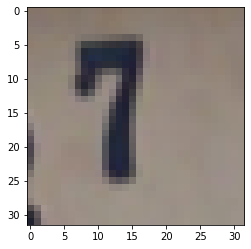

Label :  7


In [ ]:
# Optional Code just for visualization

image_ind = 99  # Any index you want to visualize
train_data = sio.loadmat('./data/train_32x32.mat')

# access to the dict
x_train = train_data['X']
y_train = train_data['y']

# show sample
plt.imshow(x_train[:,:,:,image_ind])
plt.show()


print("Label : ", y_train[image_ind].item())

In [ ]:
batch_size = 512

train_load = torch.utils.data.DataLoader(dataset = train_dataset,
                                         batch_size=512,
                                         shuffle=True)

test_load = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size=512,
                                         shuffle=True)

In [ ]:
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Notebook will use : ' + device.upper())
# Use GPU for computation

Notebook will use : CUDA


In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    # Same Padding = (filter_size-1)/2 --> (3-1)/2 = 1
    self.cnn1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1)
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.relu = nn.ReLU()
    self.cnn2 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1) 
    # The output size of each 32 features is:
    # [(input_size - filter_size + 2(padding))/stride + 1] --> 16
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.dropout = nn.Dropout(p=0.3)
    self.cnn3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.cnn4 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1)
    # The output size of each 64 features is:
    # [(input_size - filter_size + 2(padding))/stride + 1] --> 8
    self.cnn5 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.cnn6 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1)
    # The output size of each 128 features is:
    # [(input_size - filter_size + 2(padding))/stride + 1] --> 4
     # Flatten 128 feature maps 128*4*4 = 2048
    self.fc1 = nn.Linear(2048,128)
    self.dropout2 = nn.Dropout(p=0.4)
    self.fc2 = nn.Linear(128,10)
  
  def forward(self,x):
    out = self.relu(self.cnn1(x))
    out = self.batchnorm1(out)
    out = self.relu(self.cnn2(out))
    out = self.maxpool(out)
    out = self.dropout(out)
    out = self.relu(self.cnn3(out))
    out = self.batchnorm2(out)
    out = self.relu(self.cnn4(out))
    out = self.maxpool(out)
    out = self.dropout(out)
    out = self.relu(self.cnn5(out))
    out = self.batchnorm3(out)
    out = self.relu(self.cnn6(out))
    out = self.maxpool(out)
    out = self.dropout(out)
    # faltten 128 feature maps from maxpool to feed it to fc1 -->(128*4*4)
    out = out.view(-1,2048)
    # we move forward to our fully connected layer
    out = self.fc1(out)
    out = self.relu(out)
    out = self.dropout2(out)
    out = self.fc2(out)
    return out


In [ ]:
model = CNN()
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training the CNN
num_epochs = 25
train_loss = []
train_accuracy = []

for epoch in range(num_epochs):
  correct = 0
  iterations = 0
  iter_loss = 0.0

  model.train()  # We have specify that currently we are training the model because we have added dropout and batchnormalization 

  for i, (inputs,labels) in enumerate(train_load):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = loss_fn(outputs,labels)
    iter_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _,predicted = torch.max(outputs,1)
    correct += (predicted == labels).sum().item()
    iterations += 1

  train_loss.append(iter_loss/iterations)
  train_accuracy.append(100 * correct / len(train_dataset))

  print("Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}".format(
      epoch+1, num_epochs, train_loss[-1], train_accuracy[-1]))
  

Epoch 1/25, Training Loss: 1.370, Training Accuracy: 52.570
Epoch 2/25, Training Loss: 0.601, Training Accuracy: 81.258
Epoch 3/25, Training Loss: 0.477, Training Accuracy: 85.487
Epoch 4/25, Training Loss: 0.402, Training Accuracy: 87.989
Epoch 5/25, Training Loss: 0.353, Training Accuracy: 89.911
Epoch 6/25, Training Loss: 0.316, Training Accuracy: 91.209
Epoch 7/25, Training Loss: 0.293, Training Accuracy: 91.960
Epoch 8/25, Training Loss: 0.278, Training Accuracy: 92.264
Epoch 9/25, Training Loss: 0.253, Training Accuracy: 93.022
Epoch 10/25, Training Loss: 0.239, Training Accuracy: 93.478
Epoch 11/25, Training Loss: 0.230, Training Accuracy: 93.797
Epoch 12/25, Training Loss: 0.223, Training Accuracy: 94.055
Epoch 13/25, Training Loss: 0.214, Training Accuracy: 94.121
Epoch 14/25, Training Loss: 0.202, Training Accuracy: 94.485
Epoch 15/25, Training Loss: 0.193, Training Accuracy: 94.634
Epoch 16/25, Training Loss: 0.189, Training Accuracy: 94.817
Epoch 17/25, Training Loss: 0.182

In [ ]:
def progress(curr, total, suffix=''):
  bar_len = 48
  filled = int(round(bar_len * curr / float(total)))
  if filled == 0:
    filled = 1
  bar = '=' * (filled - 1) + '>' + '-' * (bar_len - filled)
  sys.stdout.write('\r[%s] .. %s' % (bar, suffix))
  sys.stdout.flush()
  if curr == total:
    bar = bar_len * '='
    sys.stdout.write('\r[%s] .. %s .. Completed\n' % (bar, suffix))
# Referenced from workshop notebook. 

In [ ]:
correct = 0
model.eval()
for j, (images, labels) in enumerate(test_load):
  images, labels = images.to(device), labels.to(device)
  logits = model(images)
  _, preds = torch.max(logits, 1)
  correct += (preds == labels).sum().item()
  progress(j+1, len(test_load), 'Batch [{}/{}]'.format(j+1, len(test_load)))
model.train()
print('Accuracy = {}%'.format(float(correct) * 100 / len(test_dataset)))

[================================================] .. Batch [51/51] .. Completed
Accuracy = 95.55931161647203%


In [ ]:
torch.save(model.state_dict(), 'model.pt')

In [ ]:
MODEL = CNN()
MODEL = MODEL.to(device)

In [ ]:
MODEL.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
correct = 0
MODEL.eval()
for j, (images, labels) in enumerate(test_load):
  images, labels = images.to(device), labels.to(device)
  logits = model(images)
  _, preds = torch.max(logits, 1)
  correct += (preds == labels).sum().item()
  progress(j+1, len(test_load), 'Batch [{}/{}]'.format(j+1, len(test_load)))
MODEL.train()
print('Accuracy = {}%'.format(float(correct) * 100 / len(test_dataset)))

[================================================] .. Batch [51/51] .. Completed
Accuracy = 93.4119545175169%


In [ ]:
!touch model.py